In [1]:
# ARIMA Forecasting on Rapeseed Oil Production to 2025, and Honey Production Prediction for 2023
## Sara Slocum

In [2]:
import pandas as pd
import numpy as np
import pmdarima as pm
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest
import matplotlib.pyplot as plt
from matplotlib import pyplot
from math import sqrt
from numpy import split
from numpy import array
import statsmodels
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sympy.solvers import solve
from sympy import Symbol

In [3]:
# Importing dataframe
Global = pd.read_csv("C:/Users/saslo/Data_Science/DS_Portfolio/Queen_Bees/Datasets/Wrangled_Data/usdaGlobal_HighCorr_Honey.csv")

Global

,Commodity_Description,Year,Value,Country_Code,Country_Name,Attribute_Description,Unit_Description
0,"Almonds, Shelled Basis",1998,235884,US,United States,Production,(MT)
1,"Almonds, Shelled Basis",1999,377800,US,United States,Production,(MT)
2,"Almonds, Shelled Basis",2000,318900,US,United States,Production,(MT)
3,"Almonds, Shelled Basis",2001,376500,US,United States,Production,(MT)
4,"Almonds, Shelled Basis",2002,494416,US,United States,Production,(MT)
...,...,...,...,...,...,...,...
307,"Walnuts, Inshell Basis",2017,589670,US,United States,Production,(MT)
308,"Walnuts, Inshell Basis",2018,625958,US,United States,Production,(MT)
309,"Walnuts, Inshell Basis",2019,594206,US,United States,Production,(MT)
310,"Walnuts, Inshell Basis",2020,712140,US,United States,Production,(MT)


In [4]:
# Reshaping data for time series analysis
pivoted = Global.pivot(index='Year', columns='Commodity_Description', values='Value')\
            .reset_index()
pivoted.columns.name=None
print(pivoted)

    Year  Almonds, Shelled Basis  Apples, Fresh      Barley  Coffee, Green  \
0   1998                  235884        5282724   235884000       14153040   
1   1999                  377800        5746060   361362000       21681720   
2   2000                  318900        5675890   303700000       18222000   
3   2001                  376500        5065060   376488000       22589280   
4   2002                  494416        4605810   494416000   268606500000   
5   2003                  471740        4780600   458582000    27759840000   
6   2004                  462664        5683040   462664000    23231160000   
7   2005                  415040        5261960  4734966000    21681720000   
8   2006                  508023        5351610  5282724000   316963440000   
9   2007                  630500        4154195  5683040000   288041160000   
10  2008                  739400        4508344  5261960000   256452240000   
11  2009                  639600        4505000  5351610000   23

In [6]:
# Isolating Rapeseed Oil for ARIMA
justrapeseedoil = pivoted[['Year', 'Oil, Rapeseed']]
justrapeseedoil

,Year,"Oil, Rapeseed"
0,1998,3797778000
1,1999,3946939000
2,2000,4354875000
3,2001,4433333000
4,2002,4113333000
5,2003,4101899000
6,2004,77535000
7,2005,332092000
8,2006,4154195000
9,2007,625960000


In [8]:
# Formatting Year to date datatype 
justrapeseedoil['Year'] = pd.to_datetime(justrapeseedoil['Year'], format='%Y')

C:\Users\saslo\AppData\Local\Temp/ipykernel_48776/2724742517.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  justrapeseedoil['Year'] = pd.to_datetime(justrapeseedoil['Year'], format='%Y')


In [9]:
## Setting Year as index
justrapeseedoil.set_index('Year', inplace=True)
type(justrapeseedoil)

pandas.core.frame.DataFrame

<AxesSubplot:xlabel='Year'>

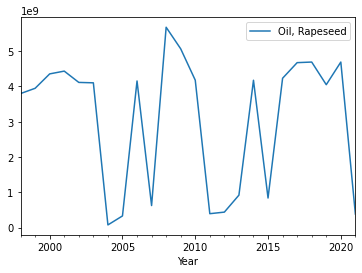

In [10]:
## Looking at linear plot of rapeseed oil production
justrapeseedoil.plot()

In [11]:
### Linear plot could be stationary, either that or a slight downward trend over time

In [12]:
## Testing our finding against Augmented Dickey Fuller test
result=adfuller(justrapeseedoil['Oil, Rapeseed'], autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -3.73614489748813
n_lags: 0.0036325328198953317
p-value: 0.0036325328198953317
Critial Values:
   1%, -3.7529275211638033
Critial Values:
   5%, -2.998499866852963
Critial Values:
   10%, -2.6389669754253307


In [14]:
### It looks like the p-value is significant, therefore our data is stationary! No differencing needed!

In [15]:
# Splitting the data for training and testing
train = justrapeseedoil[:20]
test = justrapeseedoil[-4:]
train
test

,"Oil, Rapeseed"
Year,
2018-01-01,4690101000
2019-01-01,4048993000
2020-01-01,4690101000
2021-01-01,384778000


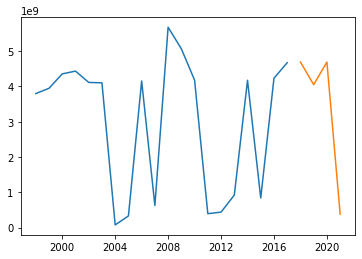

In [16]:
plt.plot(train)
plt.plot(test)

In [17]:
## Running auto_arima to obtain p, d, q variables
model = pm.auto_arima(justrapeseedoil['Oil, Rapeseed'], seasonal=False)
model

ARIMA(order=(0, 0, 0), scoring_args={}, suppress_warnings=True)

In [18]:
### As expected, our model needs no differencing, and with seasonal set to false it looks like our optimal parameters are p=0 d=0 q=0. Lets try it with seasonal differencing.

In [19]:
# Manually Building Auto ARIMA model
arima_model =  auto_arima(train,start_p=0, d=0, start_q=0, 
                          max_p=5, max_d=5, max_q=5, start_P=0, 
                          D=0, start_Q=0, max_P=5, max_D=5,
                          max_Q=5, m=12, seasonal=True, 
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=20,n_fits = 50 )

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=915.119, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=917.655, Time=0.03 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=917.366, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=938.561, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=916.630, Time=0.02 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=914.793, Time=0.02 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=916.725, Time=0.03 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=916.549, Time=0.04 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=918.491, Time=0.05 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=916.775, Time=0.02 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=919.115, Time=0.03 sec
 ARIMA(0,0,0)(0,0,1)[12]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,1)[12] intercept
Total fit time: 0.307 seconds


In [20]:
#Summary of the model
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                  
==================================================================================
Dep. Variable:                          y   No. Observations:                   20
Model:             SARIMAX(0, 0, [1], 12)   Log Likelihood                -454.396
Date:                    Mon, 18 Jul 2022   AIC                            914.793
Time:                            14:14:43   BIC                            917.780
Sample:                                 0   HQIC                           915.376
                                     - 20                                         
Covariance Type:                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.027e+09   1.21e-09    2.5e+18      0.000    3.03e+09    3.03e+09
ma.S.L12      -0.4534      0.835     -0.543      0.587      -2.089       1.183
sigma2      3.566e+18   1.95e-19   1.83e+37      0.000    3.57e+18    3.57e+18
===================================================================================
Ljung-Box (L1) (Q):                   0.27   Jarque-Bera (JB):                 2.28
Prob(Q):                              0.60   Prob(JB):                         0.32
Heteroskedasticity (H):               1.30   Skew:                            -0.44
Prob(H) (two-sided):                  0.74   Kurtosis:                         1.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [21]:
# Forecasting on the test data
prediction = pd.DataFrame(arima_model.predict(n_periods = 4),index=test.index)
prediction.columns = ['predicted_values']
prediction

,predicted_values
Year,
2018-01-01,2.602432e+09
2019-01-01,3.929398e+09
2020-01-01,2.030123e+09
2021-01-01,2.259856e+09


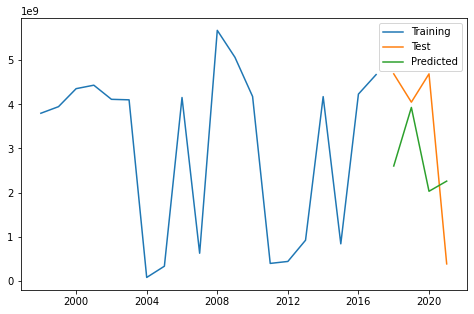

In [22]:
# Plotting against actual values
plt.figure(figsize=(8,5))
plt.plot(train,label="Training")
plt.plot(test,label="Test")
plt.plot(prediction,label="Predicted")
plt.legend(loc = 'best')
plt.show()

In [23]:
# Looking at R2 score
test['predicted_values'] = prediction
r2_score(test['Oil, Rapeseed'], test['predicted_values'])

C:\Users\saslo\AppData\Local\Temp/ipykernel_48776/2827597811.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predicted_values'] = prediction


-0.16633121690941888

In [24]:
## Not too far from zero. Our plot doesn't look the greatest paired against testing set, but our R2 score is fairly decent.

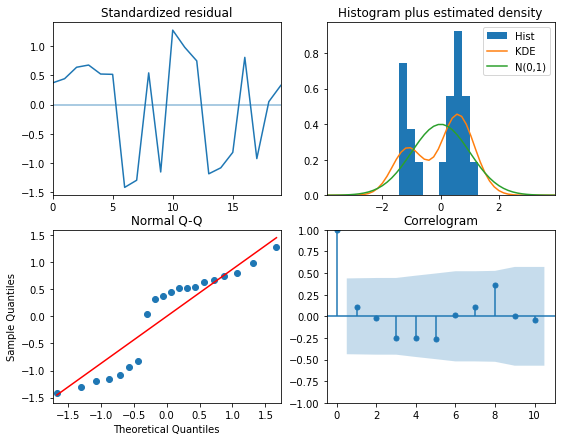

In [25]:
# Interpreting residual plots
arima_model.plot_diagnostics(figsize=(9,7))
plt.show()

In [26]:
# Creating new dataframe for future forecasting
future = {'Year':  [2022, 2023, 2024, 2025],
        'predicted_values': ['NaN', 'NaN', 'NaN', 'NaN']}

future = pd.DataFrame(future)
print (future)

   Year predicted_values
0  2022              NaN
1  2023              NaN
2  2024              NaN
3  2025              NaN


In [27]:
# Formatting Year to date datatype 
future['Year'] = pd.to_datetime(future['Year'], format='%Y')

In [28]:
## Setting Year as index
future.set_index('Year', inplace=True)
type(future)
future

,predicted_values
Year,
2022-01-01,NaN
2023-01-01,NaN
2024-01-01,NaN
2025-01-01,NaN


In [29]:
# Appending Future DF to justalmonds DF
futureprediction = justrapeseedoil.append(future)
futureprediction

,"Oil, Rapeseed",predicted_values
Year,,
1998-01-01,3.797778e+09,NaN
1999-01-01,3.946939e+09,NaN
2000-01-01,4.354875e+09,NaN
2001-01-01,4.433333e+09,NaN
2002-01-01,4.113333e+09,NaN
2003-01-01,4.101899e+09,NaN
2004-01-01,7.753500e+07,NaN
2005-01-01,3.320920e+08,NaN
2006-01-01,4.154195e+09,NaN


In [30]:
# Setting number of points to forecast
h=28
# Generating forecast
forecast2 = pd.DataFrame(arima_model.predict(h), index=futureprediction.index)
forecast2.columns = ['predicted_values']
forecast2

,predicted_values
Year,
1998-01-01,2.602432e+09
1999-01-01,3.929398e+09
2000-01-01,2.030123e+09
2001-01-01,2.259856e+09
2002-01-01,2.395385e+09
2003-01-01,4.027452e+09
2004-01-01,3.940761e+09
2005-01-01,3.717217e+09
2006-01-01,2.344646e+09


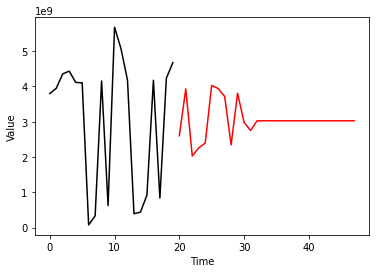

In [31]:
# Visualize forecast with training data
time = np.arange(train.shape[0] + h)

# Slice the x-axis to only plot the training data as the color black
plt.plot(time[:train.shape[0]], train, c = 'black')

# Slice the x-axis to plot our forecast after the training data as the color red
plt.plot(time[train.shape[0]:], forecast2, c = 'red')

# Set axis labels
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

In [32]:
### 
### Rapeseed Oil = -7.709(Honey) + 1,028,000
### 3.026541e+09 = -7.709(Honey) + 1,028,000
### 3,036,541,000 = -7.709(Honey) + 1,028,000
3036541000 - 1028000

3035513000

In [33]:
### 3035513000  = -7.709(Honey)
3035513000 / -7.709

-393762225.96964586

In [ ]:
### Honey = -393,762,225.97